# Characterisation of Land Surface Temperature Seasonal Variation

### Reload time series of City of Bristol urban zone land surface temperature datasets

In [1]:
import os
import math
import datetime

import xarray as xr
import pandas as pd

# define repo name and get root working directory
repo = 'uhi'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
print ( os.getcwd() )

C:\Users\crwil\Documents\GitHub\uhi\notebooks


In [2]:
# pickle utility functions
import pickle 

# serialise to pickle file
def saveToPickle( obj, pathname ):
    with open( pathname, 'wb') as f:
        pickle.dump( obj, f )
        
    return
        
# load from pickle file
def loadFromPickle( pathname ):
    
    obj = None
    try:
        # try to load file
        with open( pathname, 'rb') as f:
            obj = pickle.load( f )
            print ( f'.. loaded {pathname}' )
    except:
        pass
        
    return obj        

In [3]:
# years and zones
years = [ 2015, 2016, 2017, 2018, 2019, 2020, 2021 ]
zones = [ 'urban', 'rural' ]

In [4]:
# load 1-d timeseries statistics as dataframe from file
raw = dict()
for year in years:

    raw [ year ] = dict()
    for zone in zones:
    
        obj = loadFromPickle( f'{zone}_{year}.pkl' )        
        raw[ year ][ zone ] = obj[ obj[ 'percentCount' ] > 5 ]
                
raw[ 2015 ][ 'urban' ]

.. loaded urban_2015.pkl
.. loaded rural_2015.pkl
.. loaded urban_2016.pkl
.. loaded rural_2016.pkl
.. loaded urban_2017.pkl
.. loaded rural_2017.pkl
.. loaded urban_2018.pkl
.. loaded rural_2018.pkl
.. loaded urban_2019.pkl
.. loaded rural_2019.pkl
.. loaded urban_2020.pkl
.. loaded rural_2020.pkl
.. loaded urban_2021.pkl
.. loaded rural_2021.pkl


,lst_mean,lst_stdev,dataCount,percentCount
datetime,,,,
2015-01-10,278.635426,1.249565,225,18.382353
2015-01-19,276.094460,0.454974,309,28.637627
2015-02-04,277.153341,0.485625,347,32.159407
2015-02-27,282.697311,0.898922,741,58.208955
2015-03-24,284.539228,3.675387,299,27.710843
2015-04-09,297.420316,1.459167,644,59.684893
2015-04-16,292.056867,2.393557,305,24.918301
2015-05-11,287.441017,2.261171,122,11.306766
2015-05-18,288.943040,1.997258,391,30.714847


### Resample and smooth Landsat 8/9 measured land surface temperature annual curves

In [5]:
import numpy as np
from tsmoothie.smoother import LowessSmoother

# utility smoothing function
def smoothTimeSeries( da, smooth_fraction=0.1, iterations=1 ):

    # operate smoothing - many options here
    smoother = LowessSmoother(smooth_fraction=smooth_fraction, iterations=iterations)
    return np.ravel( smoother.smooth( da ).smooth_data )

In [6]:
smooth = dict()
for year in years:
    
    # generate smoothed version of lst timeseries
    smooth [ year ] = dict()
    for zone in zones:

        # convert data frame to xarray
        ds = raw[ year ][ zone ].to_xarray()
        
        # resample to weekly samples
        ds = ds.resample(datetime='1W').mean('datetime')
        ds = ds.interpolate_na(dim='datetime', method='linear')
        
        # apply smoothing
        ds.lst_mean.loc[ : ] = smoothTimeSeries( ds.lst_mean, smooth_fraction=0.2 )
        smooth[ year ][ zone ] = ds

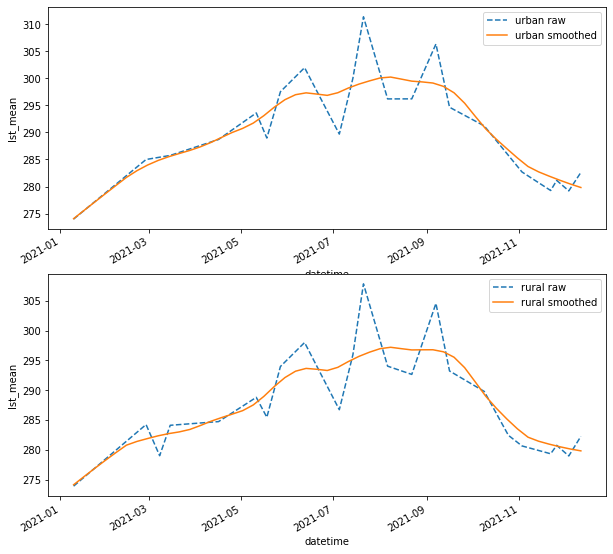

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots( figsize=(10,10), nrows=2, ncols=1 )
for idx, zone in enumerate ( zones ):
    
    # comparison between raw and smoothed versions of time series
    raw[ 2021 ][ zone ].lst_mean.plot.line(x='datetime', ax=axes[ idx ], linestyle='dashed')
    smooth[ 2021 ][ zone ].lst_mean.plot.line(x='datetime', ax=axes[ idx ] )

    axes[ idx ].legend( [ f'{zone} raw', f'{zone} smoothed' ] )

### Utility functions to compute Phenological Metrics for 1-D time series stored as XArray

In [8]:
from scipy.signal import find_peaks

def getPeaks( da ):
    
    """
    determine number of peaks exhibited by time series
    """

    # get height (val at 75% threshold) and dist between peaks - assume 4 seasons
    height = np.nanquantile( da, q=0.75)
    distance = math.ceil( len( da ) / 4)
    
    return find_peaks( da, 
                    height=height, 
                    distance=distance )

In [9]:
def getPeakofSeason( da ):
    
    """
    get day of year and value of maximum value across time series 
    """    
    return float( da.max('datetime').values ), da.argmax( 'datetime', skipna=True)

In [10]:
def getValleyofSeason( da ):
    
    """
    get day of year and value of minimum value across time series 
    """
    return float( da.min('datetime').values ), da.argmin( 'datetime', skipna=True )

In [11]:
def getMiddleofSeason( da, pos_doy ):
        
    """
    middle of season is calculated as the mean value at 80% to left and right of the peak of season (pos)
    """
        
    # get gradient left and right of pos
    slope_l = da.where(da['datetime.dayofyear'] <= pos_doy )
    slope_r = da.where(da['datetime.dayofyear'] >= pos_doy )
        
    # getupper 80% values in positive slope on left and right
    slope_l_upper = slope_l.where(slope_l >= (slope_l.max('datetime') * 0.8))
    slope_r_upper = slope_r.where(slope_r >= (slope_r.max('datetime') * 0.8))

    # get means of slope left and right
    slope_l_mean = slope_l_upper.mean('datetime')
    slope_r_mean = slope_r_upper.mean('datetime')

    # combine left and right veg_index means
    return float ( ( (slope_l_mean + slope_r_mean) / 2 ).values )

In [12]:
def getBaseValue( da, pos_doy ):
    
    """
    base value is calculated as mean value of two minimum values; 
        1. the min of the slope to the left of peak of season, and
        2. the min of the slope to the right of the peak of season.
    """
        
    # split timeseries into left and right slopes via provided peak/middle values
    slope_l = da.where(da['datetime.dayofyear'] <= pos_doy ).min('datetime')
    slope_r = da.where(da['datetime.dayofyear'] >= pos_doy ).min('datetime')

    # get per pixel mean of both left and right slope min values 
    return float( ( (slope_l + slope_r) / 2 ).values )    

In [13]:
def getAmplitude( pos, bse ):    
    
    """
    difference between peak and base values
    """
    
    return pos - bse

In [14]:
class StartofSeason():
    
    """
    compute start of season metrics
    """
    
    @staticmethod
    def getFirstofSlope( da, peak_doy ):
        
        # get left slopes values, calc differentials 
        slope_l = da.where(da['datetime.dayofyear'] <= peak_doy )
        slope_l_diffs = slope_l.differentiate('datetime')
        
        # subset to positive differentials
        slope_l_pos_diffs = xr.where(slope_l_diffs > 0, True, False)

        # select values where positive on left slope
        slope_l_pos = slope_l.where( slope_l_pos_diffs )

        # get median on pos left slope, calc vege dists from median
        slope_l_med = slope_l_pos.median('datetime')
        dists_from_median = slope_l_pos - slope_l_med 

        # get time index where min dist from median (first on slope)
        i = dists_from_median.argmin('datetime', skipna=True)

        # get start of season values and times (day of year)
        return float( slope_l_pos.isel(datetime=i, drop=True).values ), \
                int( slope_l_pos['datetime.dayofyear'].isel(datetime=i, drop=True).values )
    
    @staticmethod
    def getMedianofSlope( da, peak_doy ):

        # get left slopes values, calc differentials, subset to positive differentials
        slope_l = da.where(da['datetime.dayofyear'] <= peak_doy )
        slope_l_diffs = slope_l.differentiate('datetime')
        slope_l_pos_diffs = xr.where(slope_l_diffs > 0, True, False)

        # select values where positive on left slope
        slope_l_pos = slope_l.where(slope_l_pos_diffs)

        # get median on pos left slope, calc absolute dists from median
        slope_l_med = slope_l_pos.median('datetime')
        dists_from_median = slope_l_pos - slope_l_med
        dists_from_median = abs(dists_from_median)

        # get time index where min absolute dist from median (median on slope)
        i = dists_from_median.argmin('datetime', skipna=True)

        # get start of season values and times (day of year)
        return float( slope_l_pos.isel(datetime=i, drop=True).values ), \
                int( slope_l_pos['datetime.dayofyear'].isel(datetime=i, drop=True).values )


In [15]:
class EndofSeason():
    
    """
    compute end of season metrics
    """
    
    @staticmethod
    def getFirstofSlope( da, peak_doy ):
                    
        # get right slopes values, calc differentials, subset to negative differentials
        slope_r = da.where(da['datetime.dayofyear'] >= peak_doy )
        slope_r_diffs = slope_r.differentiate('datetime')
        slope_r_neg_diffs = xr.where(slope_r_diffs < 0, True, False)
                
        # select vege values where negative on right slope
        slope_r_neg = slope_r.where(slope_r_neg_diffs)
        
        # get median of vege on neg right slope, calc vege dists from median
        slope_r_med = slope_r_neg.median('datetime')
        dists_from_median = slope_r_neg - slope_r_med 
                
        # get time index where min dist from median (first on slope)
        i = dists_from_median.argmin('datetime', skipna=True)
        
        # get vege end of season values and times (day of year)
        return float( slope_r_neg.isel(datetime=i, drop=True).values ), \
                    int( slope_r_neg['datetime.dayofyear'].isel(datetime=i, drop=True) )
    
    @staticmethod
    def getMedianofSlope( da, peak_doy ):
    
        # get right slopes values, calc differentials, subset to positive differentials
        slope_r = da.where(da['datetime.dayofyear'] >= peak_doy)
        slope_r_diffs = slope_r.differentiate('datetime')
        slope_r_neg_diffs = xr.where(slope_r_diffs < 0, True, False)
                
        # select vege values where negative on right slope
        slope_r_neg = slope_r.where(slope_r_neg_diffs)
        
        # get median of vege on neg right slope, calc absolute vege dists from median
        slope_r_med = slope_r_neg.median('datetime')
        dists_from_median = slope_r_neg - slope_r_med
        dists_from_median = abs(dists_from_median)
                
        # get time index where min absolute dist from median (median on slope)
        i = dists_from_median.argmin('datetime', skipna=True)
        
        # get vege start of season values and times (day of year)
        return float( slope_r_neg.isel(datetime=i, drop=True).values ), \
                int( slope_r_neg['datetime.dayofyear'].isel(datetime=i, drop=True).values )            

In [16]:
def getLengthofSeason( sos, eos ):

    """
    get length of season in days
    """
    
    return eos - sos

In [17]:
def getRateofIncrease( peak, peak_doy, sos, sos_doy ):
    
    """
    get gradient from start of season to peak value
    """

    return ( peak - sos ) / ( peak_doy - sos_doy )


In [18]:
def getRateofDecrease( peak, peak_doy, eos, eos_doy ):
    
    """
    get gradient from peak value to end of season
    """

    return abs( ( eos - peak ) / ( eos_doy - peak_doy ) )

In [19]:
from scipy.integrate import trapz

def getLongIntegralofSeason( da, sos_doy, eos_doy ):
    
    """
    compute area under curve between start and end of season
    """
    
    values = da.where((da['datetime.dayofyear'] >= sos_doy ) &
                            (da['datetime.dayofyear'] <= eos_doy ), 0 )
    
    return trapz( values, x=da['datetime.dayofyear'] )
    

In [20]:
def getLongIntegralofTotal( da ):
    
    """
    compute area under curve across entire time series
    """
    
    return trapz( da, x=da['datetime.dayofyear'] )

### Compute Phenological Metrics for smoothed land surface temperature time series

In [21]:
data = list()
for year in years:

    # focus on urban zone lst timeseries
    da = smooth[ year ][ 'urban' ].lst_mean
    metrics = { 'year' : year } 
    
    # get peaks (should be 1)
    peaks = getPeaks( da )
    metrics[ 'num_peaks' ] = len( peaks[ 0 ] )
    
    # get peak of season (value + day of year)
    metrics[ 'pos' ], idx = getPeakofSeason( da )
    metrics[ 'pos_doy' ] = int( da['datetime.dayofyear'].isel(datetime=idx, drop=True).values )
    
    # get valley of season (value + day of year)   
    metrics[ 'vos' ], idx = getValleyofSeason( da )
    metrics[ 'vos_doy' ] = int( ds['datetime.dayofyear'].isel(datetime=idx, drop=True).values )
    
    # get middle of season
    metrics[ 'mos' ] = getMiddleofSeason( da, metrics[ 'pos_doy' ] )
    
    # get base of season
    metrics[ 'bse' ] = getBaseValue( da, metrics[ 'pos_doy' ] )
    
    # get amplitude
    metrics[ 'aos' ] = getAmplitude( metrics[ 'pos'], metrics[ 'bse'] )
    #metrics[ 'aos' ] = getAmplitude( metrics[ 'pos'], metrics[ 'vos'] )

    # get start and end of season gradients
    metrics[ 'sos' ], metrics[ 'sos_doy' ] = StartofSeason.getMedianofSlope( da, metrics[ 'pos_doy' ] )    
    metrics[ 'eos' ], metrics[ 'eos_doy' ] = EndofSeason.getMedianofSlope( da, metrics[ 'pos_doy' ] )
    
    # get length of season
    metrics[ 'los' ] = getLengthofSeason( metrics[ 'sos_doy' ], metrics[ 'eos_doy'] )
    
    # get rate of increase
    metrics[ 'roi' ] = getRateofIncrease( metrics[ 'pos' ], 
                                          metrics[ 'pos_doy' ],
                                          metrics[ 'sos' ],
                                          metrics[ 'sos_doy' ] )
    
    # get rate of decrease
    metrics[ 'rod' ] = getRateofDecrease( metrics[ 'pos' ], 
                                          metrics[ 'pos_doy' ],
                                          metrics[ 'eos' ],
                                          metrics[ 'eos_doy' ] )

    # get area under curve metrics
    metrics[ 'lios' ] = getLongIntegralofSeason( da, metrics[ 'sos_doy'], metrics[ 'eos_doy' ] )
    metrics[ 'liot' ] = getLongIntegralofTotal( da )
        
    ## append to list
    data.append( metrics )

    
# convert to dataframe
results = pd.DataFrame( data )
results

,year,num_peaks,pos,pos_doy,vos,vos_doy,mos,bse,aos,sos,sos_doy,eos,eos_doy,los,roi,rod,lios,liot
0,2015,1,300.679811,179,262.769402,325,288.059861,269.674709,31.005102,286.016879,81,292.340862,256,175,0.149622,0.108298,53556.108419,90767.737715
1,2016,1,302.946903,178,279.986427,339,291.000391,280.583084,22.363820,286.073242,87,293.958790,262,175,0.185425,0.107001,53880.684583,95714.850504
2,2017,1,306.225454,169,277.401205,339,292.028769,278.863032,27.362422,286.084174,85,295.507435,253,168,0.239777,0.127595,52321.319416,96083.385206
3,2018,1,307.744990,189,276.206452,10,293.107968,278.640851,29.104139,289.941972,98,292.011873,259,161,0.195638,0.224759,50498.121649,90205.847961
4,2019,1,304.058011,202,276.469799,10,290.439304,277.658115,26.399896,290.765926,97,288.242182,272,175,0.126591,0.225940,54064.355315,93528.395785
5,2020,1,301.486726,173,273.399362,52,289.944537,279.053987,22.432738,292.335004,110,293.836348,215,105,0.145265,0.182152,33374.064524,83070.019795
6,2021,1,300.217714,220,274.064833,10,290.206352,276.945107,23.272607,289.074272,108,290.645711,283,175,0.099495,0.151937,53902.163843,97489.253535


<AxesSubplot:xlabel='year'>

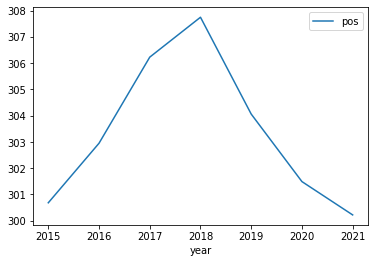

In [22]:
# plot peak of season
results.plot( x='year', y='pos' )

In [23]:
# visualise phenological metrics for 2018 seasonal curve
year = 2018
metrics = results[ results.year == year ].to_dict('records')[ 0 ]
metrics

{'year': 2018,
 'num_peaks': 1,
 'pos': 307.7449903222908,
 'pos_doy': 189,
 'vos': 276.20645198316646,
 'vos_doy': 10,
 'mos': 293.1079683657924,
 'bse': 278.6408511247475,
 'aos': 29.104139197543304,
 'sos': 289.94197194220317,
 'sos_doy': 98,
 'eos': 292.0118730652504,
 'eos_doy': 259,
 'los': 161,
 'roi': 0.1956375646163475,
 'rod': 0.22475881795771946,
 'lios': 50498.1216489023,
 'liot': 90205.84796137079}

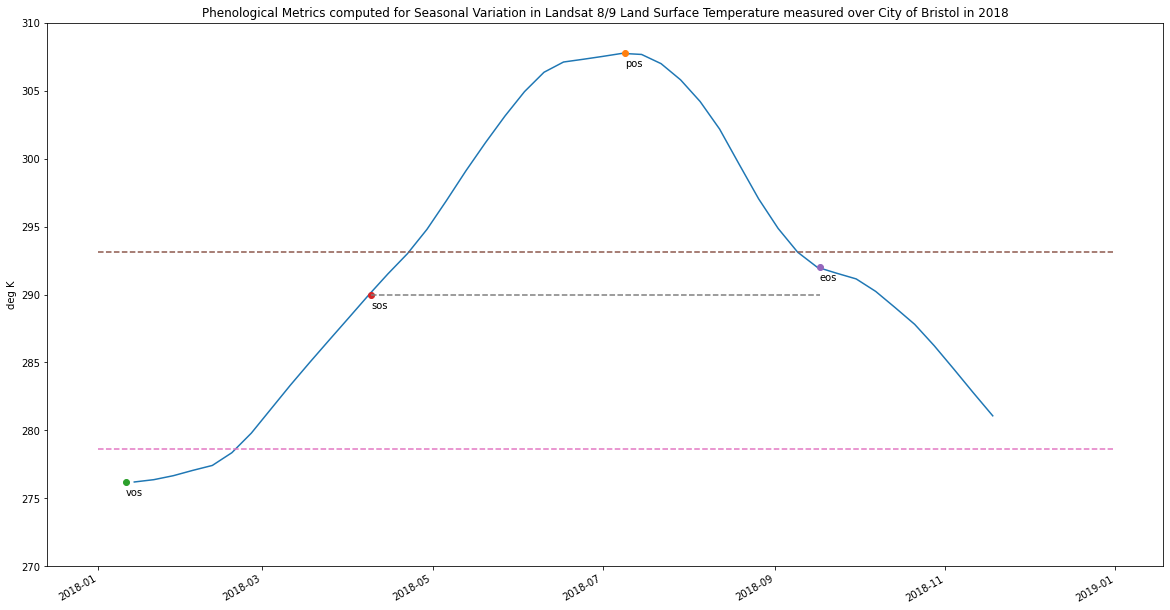

In [24]:
# utility function
def plotAnnotation( x, y, t, label ):

    ax.plot( x, y, t, zorder=10 )
    
    if not isinstance( x, list ):
        # single point
        ax.annotate( label, ( x, y - 1  ), transform=ax.transAxes )
        
    else:
        
        # compute centroid of assumed line
        delta = x[ 1 ]  - x[ 0 ]         

        xc = x[ 0 ] + datetime.timedelta(days=delta.days / 2 )
        yc = ( y[ 0 ] + y[ 1 ] ) / 2.0
        
        #ax.annotate( label, ( xc, yc - 1  ) )
    return

# create time series plot
fig, ax = plt.subplots( figsize=(20,10) )
smooth[ year ][ 'urban' ].lst_mean.plot.line(x='datetime', ax=ax )

# get start of year
origin = datetime.datetime(year, 1, 1)
ax.set_ylim(270, 310)

# update axes
ax.set_xlabel('')
ax.set_ylabel('deg K')
ax.set_title( f'Phenological Metrics computed for Seasonal Variation in Landsat 8/9 Land Surface Temperature measured over City of Bristol in 2018' )

# plot annotated points
plotAnnotation( origin + datetime.timedelta(days=metrics[ 'pos_doy' ] ), metrics[ 'pos' ], 'o', 'pos' )
plotAnnotation( origin + datetime.timedelta(days=metrics[ 'vos_doy' ] ), metrics[ 'vos' ], 'o', 'vos' )
plotAnnotation( origin + datetime.timedelta(days=metrics[ 'sos_doy' ] ), metrics[ 'sos' ], 'o', 'sos' )
plotAnnotation( origin + datetime.timedelta(days=metrics[ 'eos_doy' ] ), metrics[ 'eos' ], 'o', 'eos' )

# plot lines
plotAnnotation( [ origin, origin + datetime.timedelta(days=364) ], [ metrics[ 'mos' ], metrics[ 'mos' ] ], '--', 'mos' )
plotAnnotation( [ origin, origin + datetime.timedelta(days=364) ], [ metrics[ 'bse' ], metrics[ 'bse' ] ], '--', 'bse' )
plotAnnotation( [ origin + datetime.timedelta(days=metrics[ 'sos_doy'] ), origin + datetime.timedelta(days=metrics[ 'eos_doy'] ) ], \
                 [ min( metrics[ 'sos' ], metrics[ 'eos' ] ), min( metrics[ 'sos' ], metrics[ 'eos' ] ) ], '--', 'los' ) 

